# Algoritmos de Classificação: Regressão Logística

Nós vamos utilizar o dataset Bank Marketing disponibilizado no [site da UCI](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing). Utilizaremos uma versão adaptada para os objetivos da aula e disponível na pasta `data`.

> The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the investment product would be or not subscribed.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_auc_score)

from plotting import (multiple_histograms_plot, plot_confusion_matrix, plot_roc)
import joblib

In [2]:
sns.set_context("notebook", font_scale=1.5)

In [3]:
df = pd.read_csv('../data/bank_marketing.csv')

Segue uma descrição sucinta de cada uma das colunas do dataset:

- `duration_seconds`: last contact duration, in seconds (numeric).

- `duration_minutes`: last contact duration, in minutes (numeric).

- `duration_hours`: last contact duration, in hours (numeric).

- `emp.var.rate`: employment variation rate - quarterly indicator (numeric)

- `nr.employed`: number of employees - quarterly indicator (numeric)

- `euribor3m`: euribor 3 month rate - daily indicator (numeric)

- `month`: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

- `contact`: contact communication type (1 for cellular, 2 for telephone) 

- `loan`: has personal loan? (0 for no, 1 for yes)

- `subscribed` - has the client subscribed a term deposit? (True, False)

## Preparando os dados

In [4]:
X = df.drop(columns=['month', 'subscribed'])
y = df['subscribed']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)

## Aplicando a Regressão Logística

In [6]:
logreg = LogisticRegression(solver='lbfgs')

In [7]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [8]:
y_pred[:5]

array([False, False, False, False, False])

In [9]:
accuracy_test = accuracy_score(y_test, y_pred)
print(f'accuracy (test): {accuracy_test*100:.1f}%')

accuracy (test): 88.8%


## Avaliação do modelo

### Matriz de Confusão, Precisão, Recall

In [10]:
confusion_matrix(y_test, y_pred)

array([[7315,    0],
       [ 922,    0]])

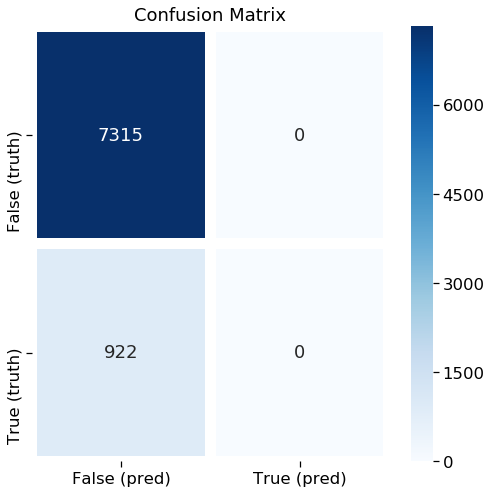

In [11]:
plot_confusion_matrix(y_test, y_pred)

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.89      1.00      0.94      7315
        True       0.00      0.00      0.00       922

    accuracy                           0.89      8237
   macro avg       0.44      0.50      0.47      8237
weighted avg       0.79      0.89      0.84      8237



/Users/gabrielcs/anaconda/envs/tera-out2019/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Utilizando as probabilidades

In [13]:
y_pred_proba = logreg.predict_proba(X_test)
y_pred_proba[:5]

array([[0.95531299, 0.04468701],
       [0.9599598 , 0.0400402 ],
       [0.77537061, 0.22462939],
       [0.96002642, 0.03997358],
       [0.77608559, 0.22391441]])

In [14]:
y_pred_proba = y_pred_proba[:, 1]
y_pred_proba[:5]

array([0.04468701, 0.0400402 , 0.22462939, 0.03997358, 0.22391441])

In [15]:
def predictions_hist(y_pred_proba, y_test, density=True):
    preds_df = pd.DataFrame(data=[y_pred_proba, y_test.astype(str)],
                            index=['Prediction', 'True Value']).T

    preds_df['Prediction'] = preds_df['Prediction'].astype(float)
    preds_df['True Value'] = preds_df['True Value'].astype(str)

    multiple_histograms_plot(data=preds_df, x='Prediction', hue='True Value',
                             bins=np.arange(0, 1.1, 0.025), density=density, probability_hist=True)

    return preds_df

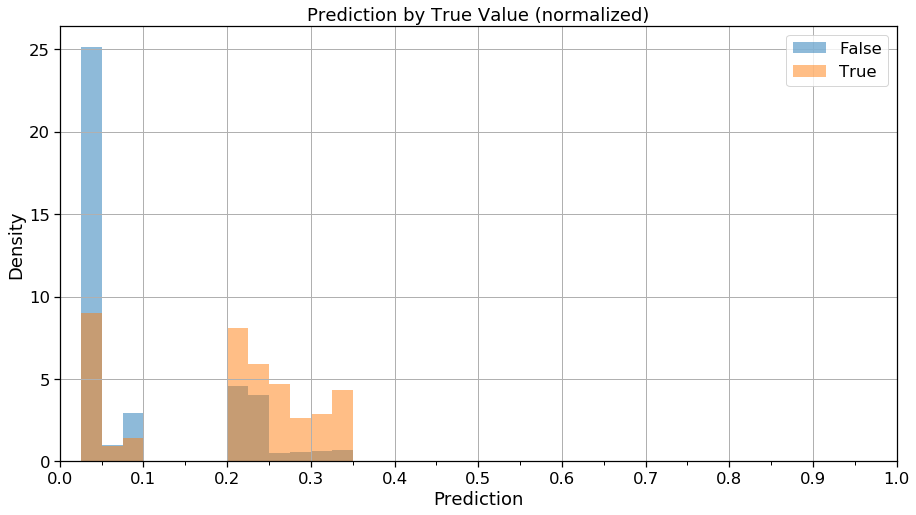

In [16]:
preds_df = predictions_hist(y_pred_proba, y_test)

In [17]:
preds_df.head()

,Prediction,True Value
0,0.044687,False
1,0.040040,False
2,0.224629,False
3,0.039974,False
4,0.223914,False


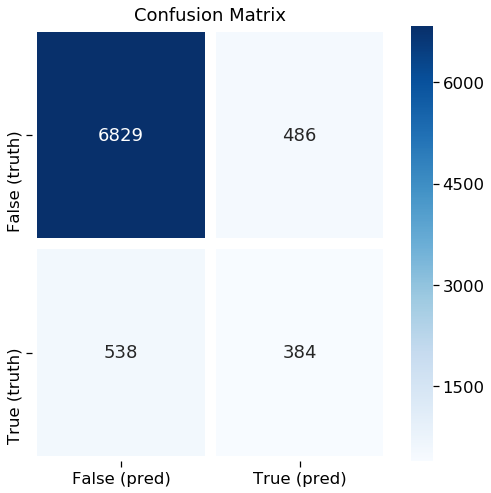

In [18]:
y_pred_customizado = y_pred_proba >= 0.23
plot_confusion_matrix(y_test, y_pred_customizado)

In [19]:
print(classification_report(y_test, y_pred_customizado))

              precision    recall  f1-score   support

       False       0.93      0.93      0.93      7315
        True       0.44      0.42      0.43       922

    accuracy                           0.88      8237
   macro avg       0.68      0.68      0.68      8237
weighted avg       0.87      0.88      0.87      8237



### Outras métricas populares

In [20]:
print(f'auc (test): {roc_auc_score(y_test, y_pred_proba):.4f}')

auc (test): 0.7692


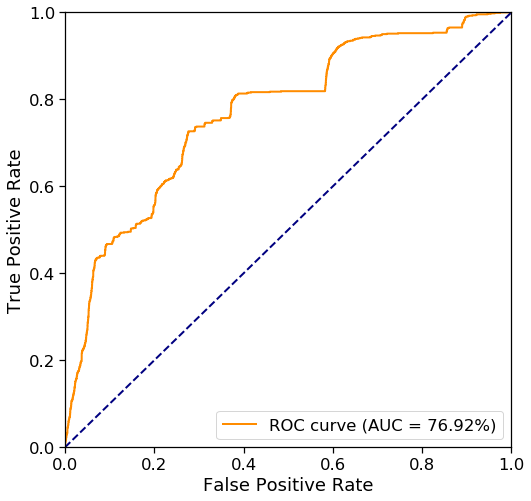

In [21]:
auc_test = plot_roc(y_test, y_pred_proba)

### Identificação de overfitting

In [22]:
y_pred_proba_train = logreg.predict_proba(X_train)[:, 1]

In [23]:
print(f'auc (train): {roc_auc_score(y_train, y_pred_proba_train):.4f}')
print(f'auc (test): {roc_auc_score(y_test, y_pred_proba):.4f}')

auc (train): 0.7628
auc (test): 0.7692


## Tentando melhorar o modelo

### Lidando com classes desbalanceadas (parâmetro `class_weight`)

In [24]:
logreg = LogisticRegression(solver='lbfgs', class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred_proba_class_weight = logreg.predict_proba(X_test)[:, 1]

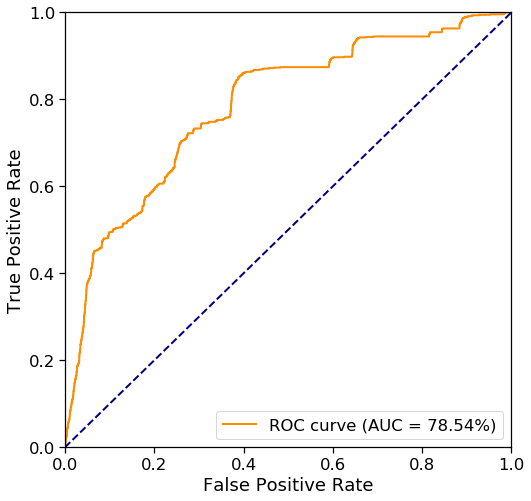

In [25]:
_ = plot_roc(y_test, y_pred_proba_class_weight)

Conseguimos ver uma melhora no AUC de 76.92% para 78.54%.

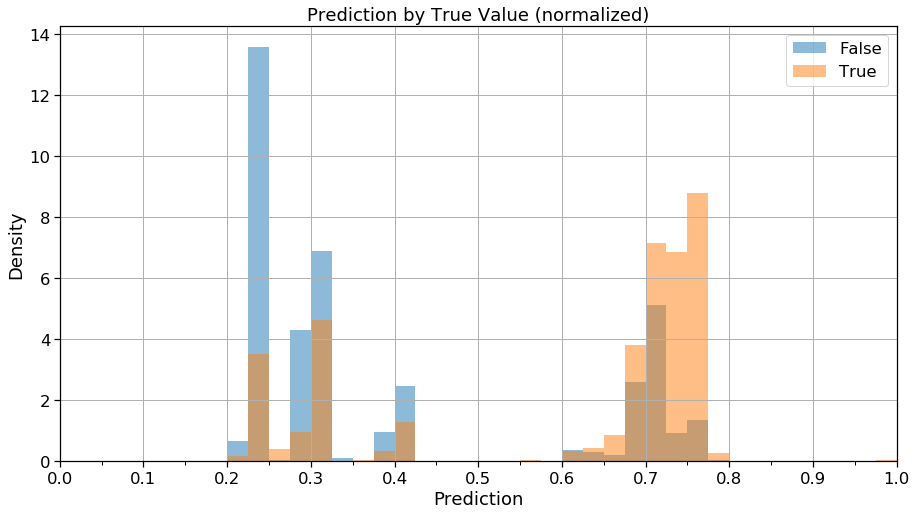

In [26]:
_ = predictions_hist(y_pred_proba_class_weight, y_test)

Ao darmos um peso maior para a classe minoritária, vemos que o modelo agora também tem predições na faixa 60%-80%.
Vamos calcular a precisão e o recall com 2 pontos de corte diferentes: 50% e 75%.

In [27]:
def confusion_matrix_report(y_test, y_pred_proba, thres=0.5):
    y_pred_proba_customizado = y_pred_proba >= thres
    print(classification_report(y_test, y_pred_proba_customizado))
    plot_confusion_matrix(y_test, y_pred_proba_customizado)

              precision    recall  f1-score   support

       False       0.95      0.73      0.82      7315
        True       0.25      0.72      0.37       922

    accuracy                           0.72      8237
   macro avg       0.60      0.72      0.60      8237
weighted avg       0.87      0.72      0.77      8237



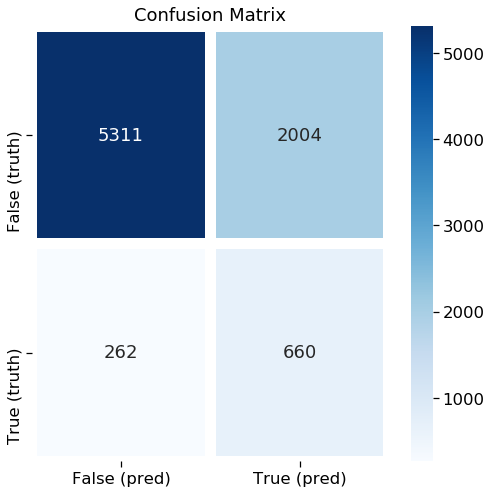

In [53]:
confusion_matrix_report(y_test, y_pred_proba_class_weight, thres=0.5)

              precision    recall  f1-score   support

       False       0.93      0.92      0.92      7315
        True       0.42      0.47      0.44       922

    accuracy                           0.87      8237
   macro avg       0.67      0.69      0.68      8237
weighted avg       0.87      0.87      0.87      8237



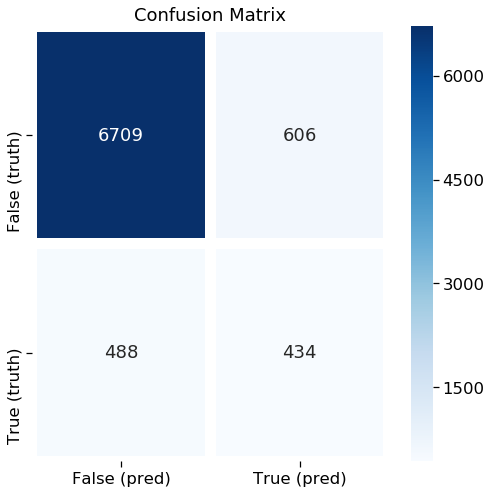

In [54]:
confusion_matrix_report(y_test, y_pred_proba_class_weight, thres=0.71)

Podemos ver que aumentando o ponto de corte, a precisão sobe (nesse caso de 25% para 42%), porém o recall diminui (no nosso caso, de 72% para 47%).

Vamos continuar no notebook de pós-aula, em que experimentarmos outras técnicas relevantes para modelos lineares: tratamento de outliers e padronização.